In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf                                   ### works with v2.11.0
from tensorflow.keras import backend as K
from UNET import UNET3D                                   ### reference the original paper: https://doi.org/10.48550/arXiv.2405.05598 if you use this module
import numpy as np
from tqdm import tqdm
import tensorflow_addons                                  ### works with v0.23.0
from astropy.stats import sigma_clip as clip 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from DensityFieldTools import DensityField3D, PkX         ### https://github.com/tsfloss/DensityFieldTools/tree/main
import matplotlib.pyplot as plt
BoxSize = 1024
kF = 2*np.pi/BoxSize
grid = 256

/net/comas/data/users/bidenko/py310/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/net/comas/data/users/bidenko/py310/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

In [2]:
physical_devices = tf.config.list_physical_devices()
physical_devices
# config = tf.config.experimental.set_visible_devices(physical_devices[0])  ### limiting to CPU only computation 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# loading test data set

In [3]:
tb = np.load('./processed_data/tb_test.npy',allow_pickle=True)
ts = np.load('./processed_data/ts_test.npy',allow_pickle=True)
x = np.load('./processed_data/xh_test.npy',allow_pickle=True)
d = np.load('./processed_data/delta_test.npy',allow_pickle=True)

In [4]:
tb.shape,ts.shape,x.shape,d.shape

((90, 256, 256, 256, 1),
 (90, 256, 256, 256, 1),
 (90, 256, 256, 256, 1),
 (90, 256, 256, 256, 1))

structure of the data files:
 [simulation index, x position, y position, z position, additional tensor axis]

computation of power of normalized cross-correlation power spectrum $P_{\times}^{\rm p}$

In [5]:
def pcross(P,i,p=2.,kcut=78):
    return (P[i][:,3][:kcut]/np.sqrt(P[i][:,2][:kcut]*P[i][:,1][:kcut]))**p

99.5% saturation cut for the $T_S$ field 

In [6]:
def data_cutts(ts=ts):
    for i in ts: 
        i[i>np.quantile(i,0.995)]=np.quantile(i,0.995)
    ts = np.array(ts)
    return ts

normalization of input data set $\delta T_b$

In [7]:
def data_norm(data,mean,std):
    data = np.array(data)
    data = data - mean
    data /= std
    return data

rescaling of the reconstructed fields

In [8]:
def rec_rescale(data,mean,std):
    data = data*std
    data = data + mean
    return data 

In [9]:
cs = 'k'
ls = '-'
lbl = "  $T_b$ x $T_S$ true"
als=1.
lws=1.
kcut= 78

def add_xplot(P,ax,poww=1.,cs=cs,als=als,lws=lws,ls=ls,lbl=lbl,kcut=kcut):
    for i in range(len(P)-1):
        ax.plot(P[i][:,0][:kcut],pcross(P,i,poww,kcut),c=cs,alpha=als,lw=lws,ls=ls),
    i=-1
    ax.plot(P[i][:,0][:kcut],pcross(P,i,poww,kcut),c=cs,alpha=als,lw=lws,label=lbl,ls=ls)
    ax.legend()

In [10]:
ts = data_cutts()

defining mean and standard deviation of the training data set fields

In [11]:
xmean,xstd = 0.99348676, 0.0198706
dmean, dstd = 4.8816316e-11, 0.10748814
tsmean,tsstd = 8.6781, 1.4251205
tbmean, tbstd = -138.4901, 13.6841755

In [12]:
tb = data_norm(tb,tbmean, tbstd)

## input - true output cross-power 

computing power spectrum and cross power spectrum of input and output field pairs

In [13]:
P_tstb = []
P_dtb = []
P_xtb = []

for i in range(len(tb)):
    P_tstb.append(PkX(ts[i,:,:,:,0],1024.,tb[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_dtb.append(PkX(d[i,:,:,:,0],1024.,tb[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_xtb.append(PkX(x[i,:,:,:,0],1024.,tb[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))

# field reconstruction

defining U-net reconstruction model architecture

In [14]:
K.clear_session()
model = UNET3D(256, n_base_filters=8,depth=5,loss_function=tf.keras.losses.mse,initial_learning_rate=1e-3)

## reconstructing $T_S$ field

In [15]:
model.load_weights("./model_weights/ts")

In [16]:
ts_rec = []
for i in tb:
     ts_rec.append(model.predict(i[np.newaxis,:,:,:])[0,:,:,:])        
ts_rec = np.array(ts_rec)

1/1 [==============================] - 0s 344ms/step


## reconstructing $\delta_b$ field

In [17]:
model.load_weights("./model_weights/d")

In [18]:
d_rec = []
for i in range(len(d)):
     d_rec.append(model.predict(tb[i][np.newaxis,:,:,:])[0,:,:,:])        
d_rec = np.array(d_rec)

1/1 [==============================] - 0s 290ms/step


## reconstructing $x_{\rm HI}$ field

In [19]:
model.load_weights("./model_weights/xh")

In [20]:
x_rec = []
for i in range(len(tb)):
     x_rec.append(model.predict(tb[i][np.newaxis,:,:,:])[0,:,:,:])        
x_rec = np.array(x_rec)

1/1 [==============================] - 0s 321ms/step


# rescaling reconstructed fields to phyisical values

In [21]:
ts_rec = rec_rescale(ts_rec,8.6781, 1.4251205)
x_rec = rec_rescale(x_rec,xmean,xstd)
tb = rec_rescale(tb,-138.4901, 13.6841755)
d_rec = rec_rescale(d_rec,4.8816316e-11, 0.10748814)

## computing cross-correlations

In [22]:
P_drectb = []
P_drecd = []
P_tsrects = []
P_tsrectb = []
P_xrectb = []
P_xrecx = []
for i in range(len(tb)):
    P_drectb.append(PkX(d_rec[i,:,:,:,0],1024.,tb[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_drecd.append(PkX(d_rec[i,:,:,:,0],1024.,d[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_tsrectb.append(PkX(ts_rec[i,:,:,:,0],1024.,tb[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_tsrects.append(PkX(ts_rec[i,:,:,:,0],1024.,ts[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_xrectb.append(PkX(x_rec[i,:,:,:,0],1024.,tb[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_xrecx.append(PkX(x_rec[i,:,:,:,0],1024.,x[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))

# plotting an example of the field slices

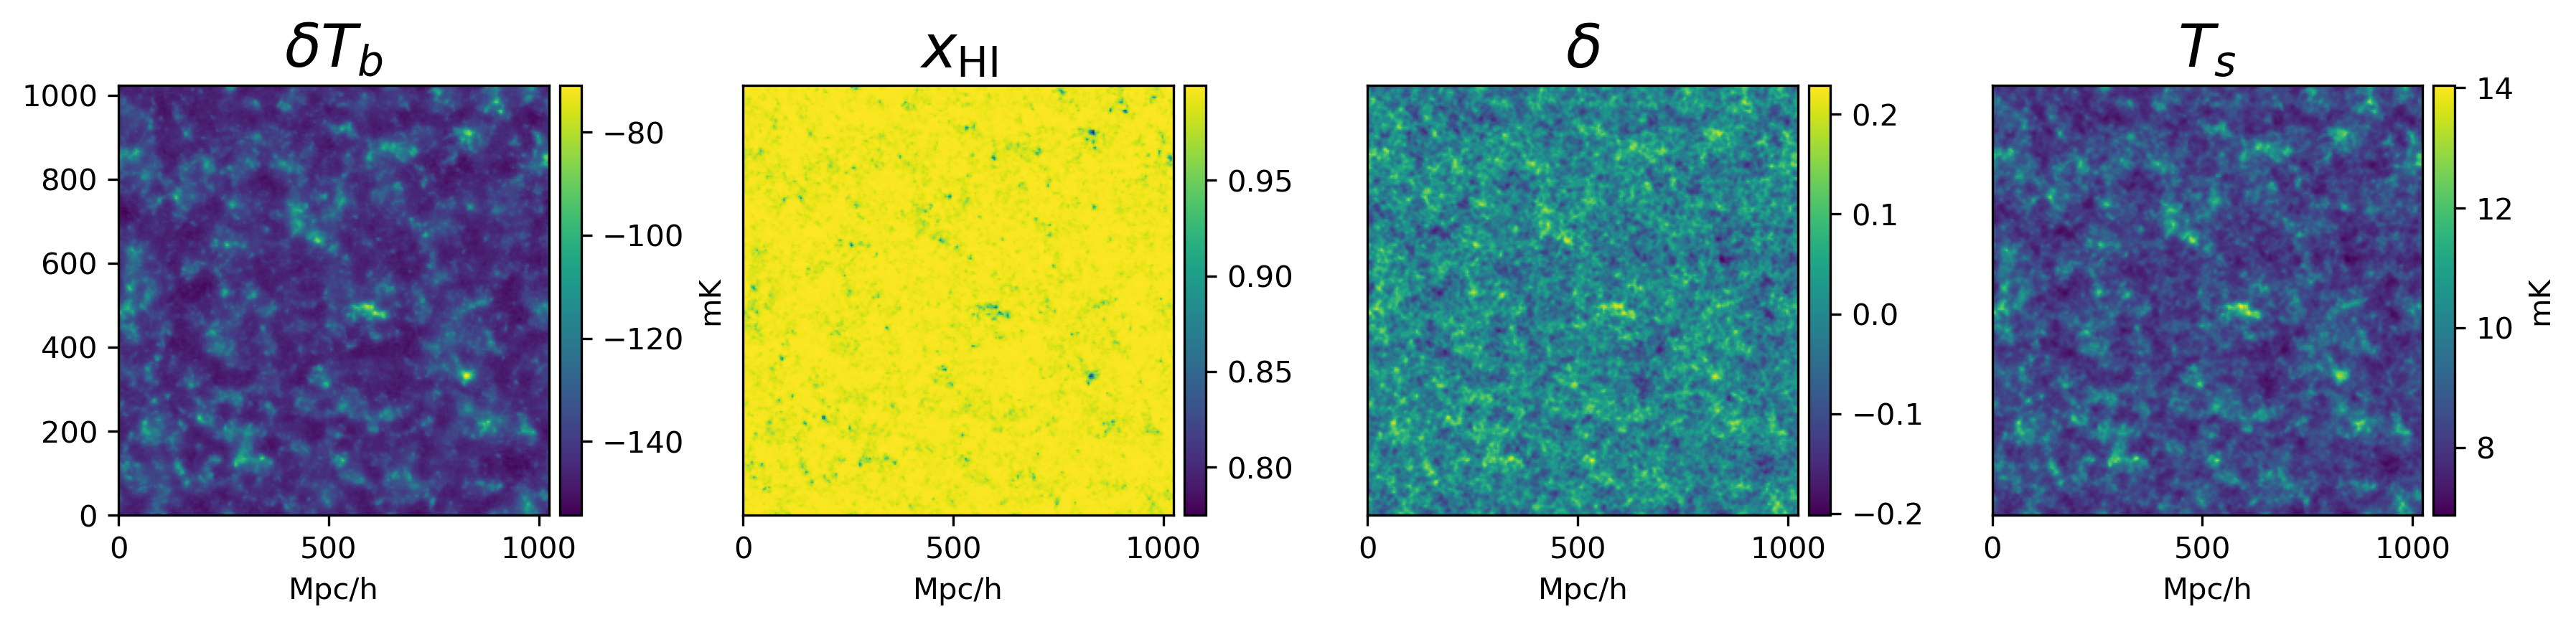

In [23]:
#realization index (0--89)
ii=84

### defining z-axis slice [0--256]
minz = 100
maxz = 120


ext=[0,1024,0,1024]
xlblfs = 10
ylblfs = 10
ticksize = 10
ttlfs = 20
cb_lbl = ['mK','','','mK']


f,ax = plt.subplots(1,4,gridspec_kw={'wspace':0.35})
f.set_dpi(300)
f.set_figwidth(14)

cb = []
cb.append(ax[0].imshow(tb[ii,:,:,minz:maxz].mean(2),extent=ext))
cb.append(ax[1].imshow((x[ii,:,:,minz:maxz,0].mean(2)),extent=ext))
cb.append(ax[2].imshow(d[ii,:,:,minz:maxz,0].mean(2),extent=ext))
cb.append(ax[3].imshow(ts[ii,:,:,minz:maxz].mean(2),extent=ext))


# setting titles, labels, and plotting colorbars

ax[0].set_title(r"$\delta T_b$",fontdict={'fontsize':ttlfs})
ax[1].set_title(r"$x_{\rm{HI}}$",fontdict={'fontsize':ttlfs})
ax[2].set_title(r"$\delta$",fontdict={'fontsize':ttlfs})
ax[3].set_title(r"$T_s$",fontdict={'fontsize':ttlfs})

for i in range(4):
    if i!=0: ax[i].set_yticks([])
    ax[i].tick_params(axis='both', labelsize=ticksize)
    ax[i].set_xlabel('Mpc/h',fontdict={'fontsize':xlblfs})
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cb[i], cax=cax,label=cb_lbl[i])


f.savefig('./fig/allfields.pdf',bbox_inches='tight')

# residual plots (Figure 3)

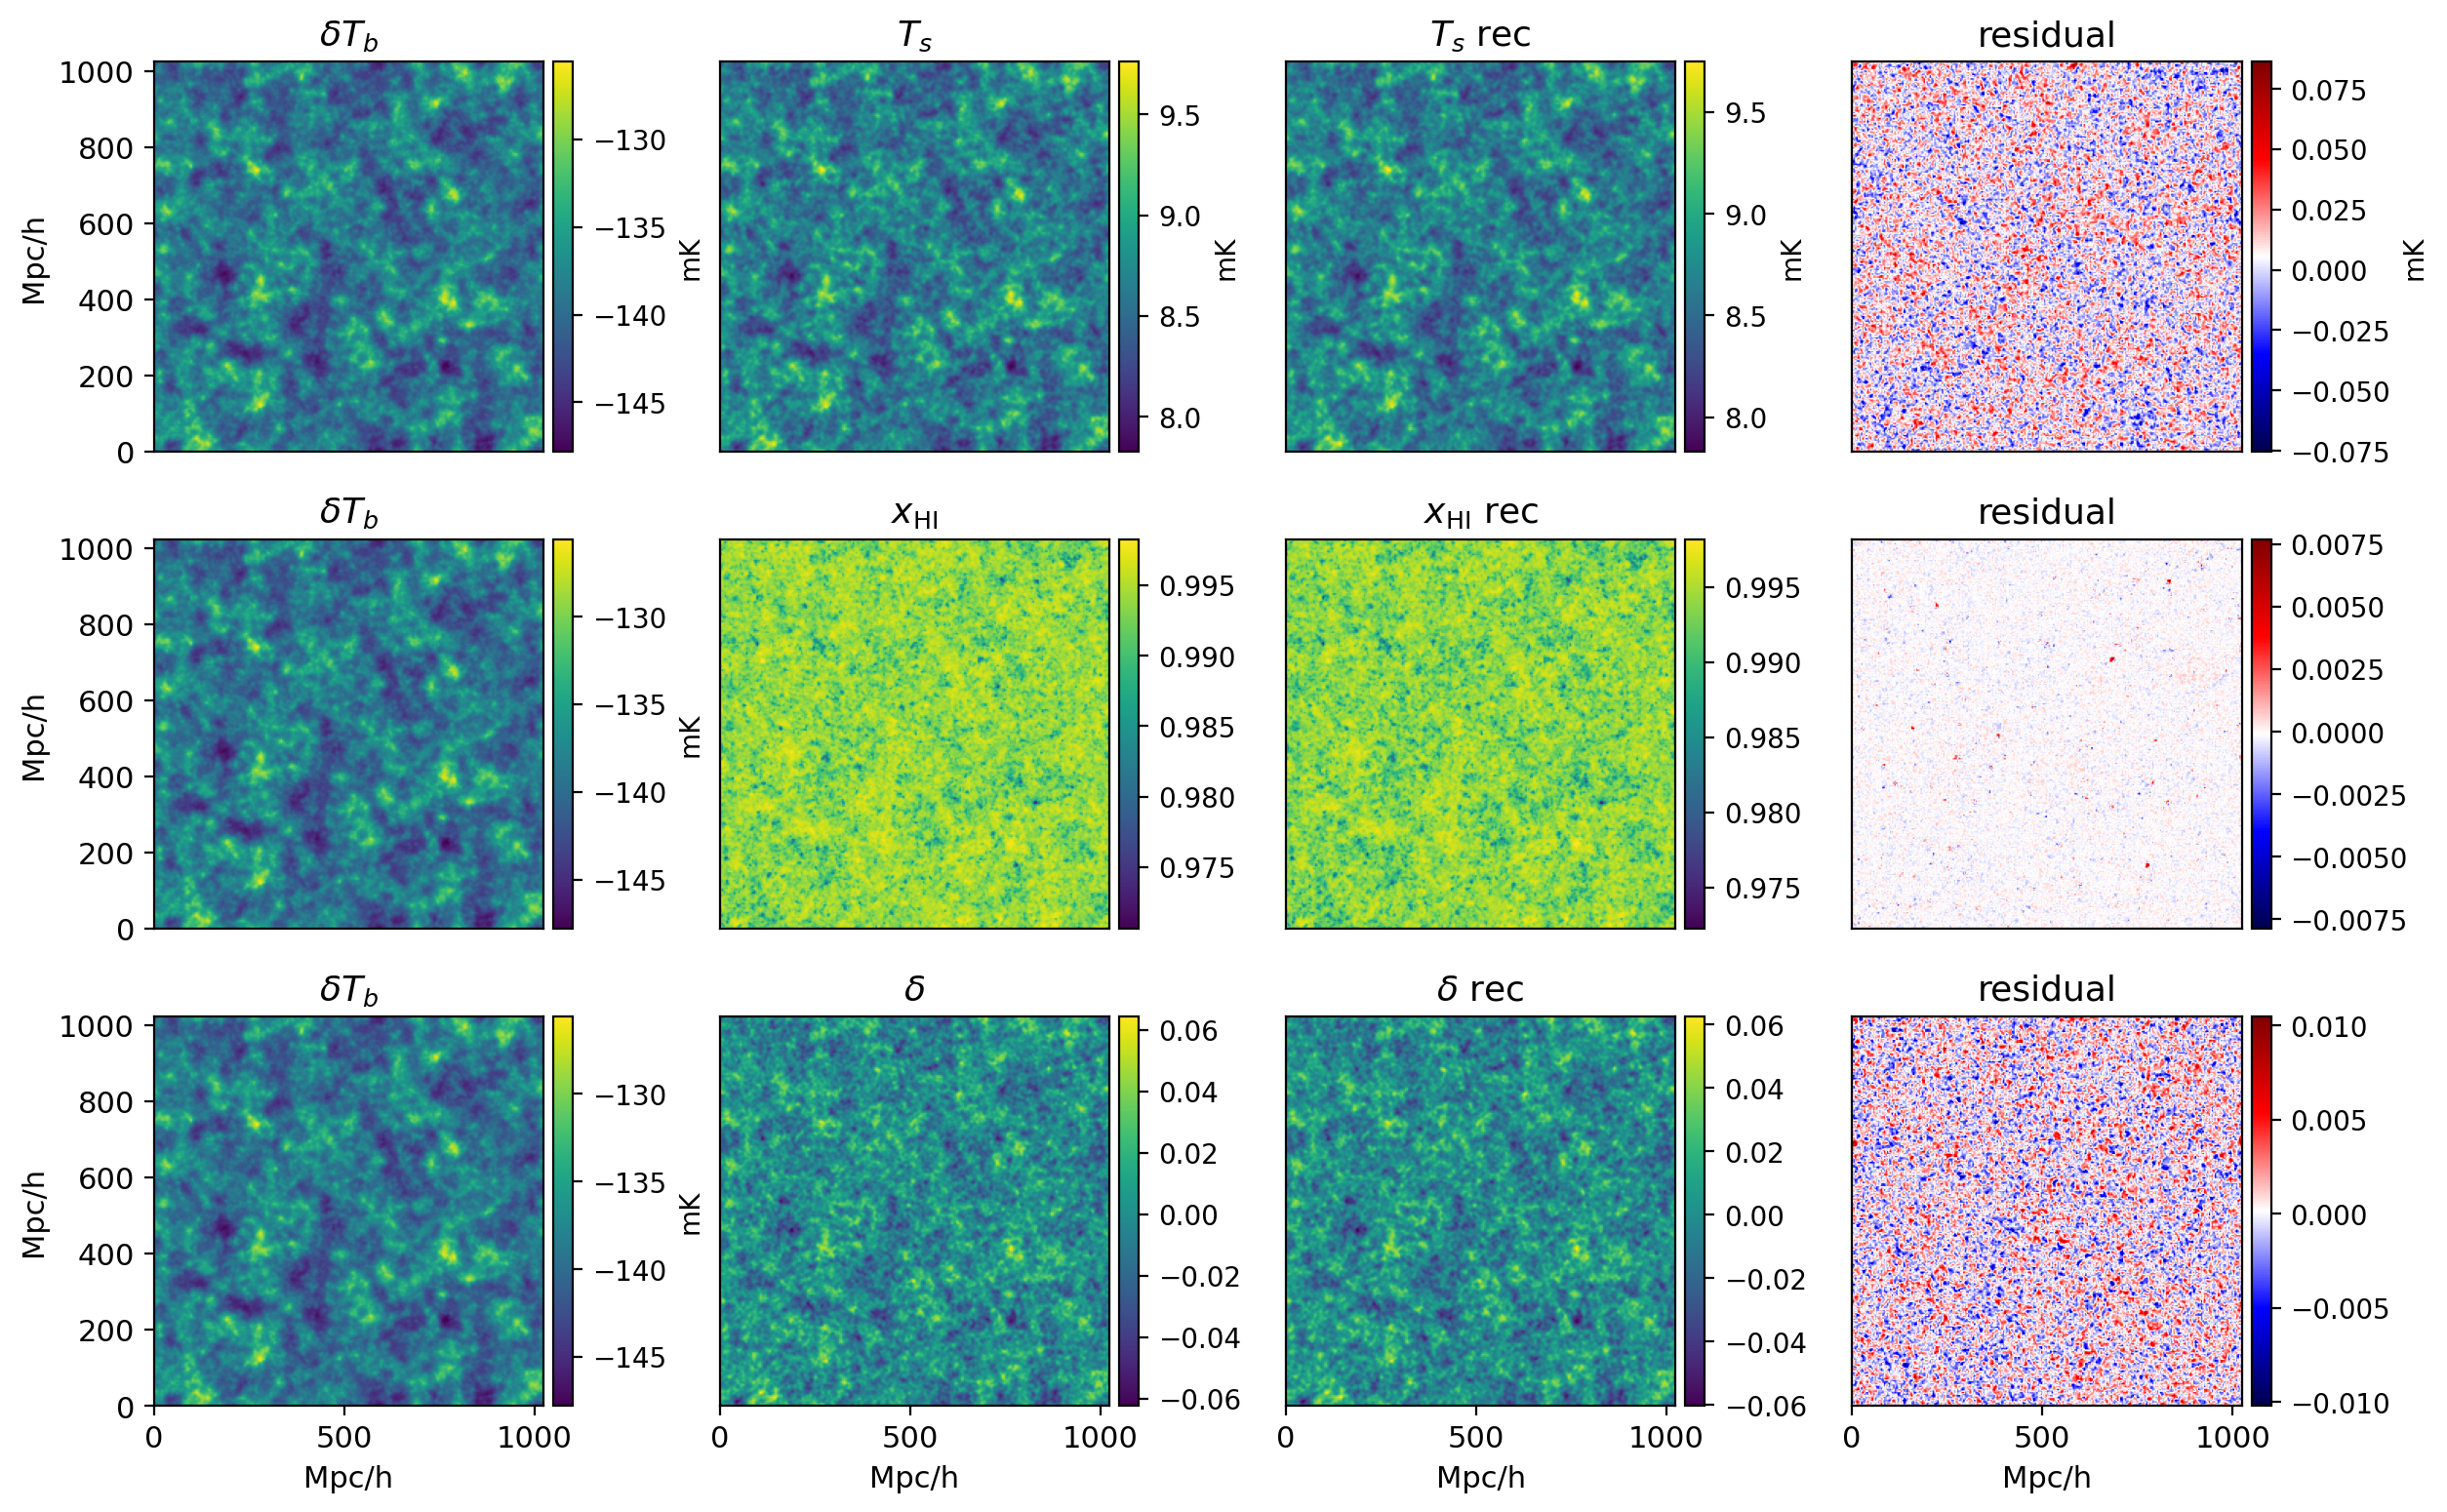

In [24]:
### setting index of plotted simulation [0--89]
ii=84

ext = [0,1024,0,1024]
### font options
xlblfs = 11
ylblfs = 11
ticksize = 11
ttlfs = 13

### defining z-axis slice [0--256]
minz = 0
maxz = 256


f,ax = plt.subplots(3,4,gridspec_kw={'wspace':0.35})
f.set_dpi(200)
f.set_figwidth(14.)
f.set_figheight(9.)

### T_S plots ### first raw

x1 = ax[0][0].imshow(tb[ii,:,:,minz:maxz,0].mean(2),extent=ext)
ax[0][0].set_ylabel('Mpc/h',fontdict={'fontsize':xlblfs})
ax[0][0].tick_params(axis='both', labelsize=ticksize)
ax[0][0].set_title(r"$\delta T_b$",fontdict={'fontsize':ttlfs})
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(x1, cax=cax,label='mK')

i1 = ax[0][1].imshow(ts[ii,:,:,minz:maxz].mean(2),extent=ext)
ax[0][1].set_title(r"$T_s$",fontdict={'fontsize':ttlfs})
divider = make_axes_locatable(ax[0][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(i1, cax=cax,label='mK')

i2= ax[0][2].imshow((ts_rec[ii,:,:,minz:maxz,0].mean(2)),extent=ext)
ax[0][2].set_title(r"$T_s$ rec",fontdict={'fontsize':ttlfs})
divider = make_axes_locatable(ax[0][2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(i2, cax=cax,label='mK')

r1=ax[0][3].imshow(ts_rec[ii,:,:,minz:maxz,0].mean(2) -ts[ii,:,:,minz:maxz,0].mean(2),extent=ext,cmap='seismic')
cl = np.max(np.abs(r1.get_clim()))
cm = np.mean(ts_rec[ii,:,:,minz:maxz,0].mean(2) -ts[ii,:,:,minz:maxz,0].mean(2))
r1=ax[0][3].imshow(ts_rec[ii,:,:,minz:maxz,0].mean(2) -ts[ii,:,:,minz:maxz,0].mean(2),vmax=cl+cm,vmin=-cl+cm,extent=ext,cmap='seismic')
divider = make_axes_locatable(ax[0][3])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[0][3].set_title(r"residual",fontdict={'fontsize':ttlfs})
plt.colorbar(r1, cax=cax,label='mK')

### x_HI plots ### second raw

x1 = ax[1][0].imshow(tb[ii,:,:,minz:maxz,0].mean(2),extent=ext)
ax[1][0].set_ylabel('Mpc/h',fontdict={'fontsize':xlblfs})
ax[1][0].tick_params(axis='both', labelsize=ticksize)
ax[1][0].set_title(r"$\delta T_b$",fontdict={'fontsize':ttlfs})
divider = make_axes_locatable(ax[1][0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(x1, cax=cax,label='mK')

i1 = ax[1][1].imshow(x[ii,:,:,minz:maxz].mean(2),extent=ext)
ax[1][1].set_title(r"$x_{\rm HI}$",fontdict={'fontsize':ttlfs})
ax[1][1].tick_params(axis='both', labelsize=ticksize)
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(i1, cax=cax)

i2= ax[1][2].imshow((x_rec[ii,:,:,minz:maxz,0].mean(2)),extent=ext)
ax[1][2].set_title(r"$x_{\rm HI}$ rec",fontdict={'fontsize':ttlfs})
ax[1][2].tick_params(axis='both', labelsize=ticksize)
divider = make_axes_locatable(ax[1][2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(i2, cax=cax)

r1=ax[1][3].imshow(x_rec[ii,:,:,minz:maxz,0].mean(2) -x[ii,:,:,minz:maxz,0].mean(2),extent=ext,cmap='seismic')
# making symmetric colorbar limits
cl = np.max(np.abs(r1.get_clim()))
cm = np.mean(x_rec[ii,:,:,minz:maxz,0].mean(2) -x[ii,:,:,minz:maxz,0].mean(2))
r1=ax[1][3].imshow(x_rec[ii,:,:,minz:maxz,0].mean(2) -x[ii,:,:,minz:maxz,0].mean(2),vmax=cl+cm,vmin=-cl+cm,extent=ext,cmap='seismic')
ax[1][3].tick_params(axis='both', labelsize=ticksize)
divider = make_axes_locatable(ax[1][3])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[1][3].set_title(r"residual",fontdict={'fontsize':ttlfs})
plt.colorbar(r1, cax=cax)

### \delta_b plots ### third raw

x1 = ax[2][0].imshow(tb[ii,:,:,minz:maxz,0].mean(2),extent=ext)
ax[2][0].set_xlabel('Mpc/h',fontdict={'fontsize':xlblfs})
ax[2][0].set_ylabel('Mpc/h',fontdict={'fontsize':xlblfs})
ax[2][0].tick_params(axis='both', labelsize=ticksize)
ax[2][0].set_title(r"$\delta T_b$",fontdict={'fontsize':ttlfs})
divider = make_axes_locatable(ax[2][0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(x1, cax=cax,label='mK')

i1 = ax[2][1].imshow(d[ii,:,:,minz:maxz].mean(2),extent=ext)
ax[2][1].set_xlabel('Mpc/h',fontdict={'fontsize':xlblfs})
ax[2][1].set_title(r"$\delta$",fontdict={'fontsize':ttlfs})
ax[2][1].tick_params(axis='both', labelsize=ticksize)
divider = make_axes_locatable(ax[2][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(i1, cax=cax)

i2= ax[2][2].imshow((d_rec[ii,:,:,minz:maxz,0].mean(2)),extent=ext)
ax[2][2].set_xlabel('Mpc/h',fontdict={'fontsize':xlblfs})
ax[2][2].set_title(r"$\delta$ rec",fontdict={'fontsize':ttlfs})
ax[2][2].tick_params(axis='both', labelsize=ticksize)
divider = make_axes_locatable(ax[2][2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(i2, cax=cax)

r1=ax[2][3].imshow(d_rec[ii,:,:,minz:maxz,0].mean(2) -d[ii,:,:,minz:maxz,0].mean(2),extent=ext,cmap='seismic')
cl = np.max(np.abs(r1.get_clim()))
cm = np.mean(d_rec[ii,:,:,minz:maxz,0].mean(2) -d[ii,:,:,minz:maxz,0].mean(2))
r1=ax[2][3].imshow(d_rec[ii,:,:,minz:maxz,0].mean(2) -d[ii,:,:,minz:maxz,0].mean(2),vmax=cl+cm,vmin=-cl+cm,extent=ext,cmap='seismic')
ax[2][3].set_xlabel('Mpc/h',fontdict={'fontsize':xlblfs})
ax[2][3].tick_params(axis='both', labelsize=ticksize)
divider = make_axes_locatable(ax[2][3])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[2][3].set_title(r"residual",fontdict={'fontsize':ttlfs})
cbar = plt.colorbar(r1, cax=cax)


### removing unnecessary axis ticks
for i in [0,1,2]:
    for j in [1,2,3]:
        ax[i][j].set_yticks([])
        
for i in [0,1]:
    for j in [0,1,2,3]:
        ax[i][j].set_xticks([])
        
f.savefig('./fig/residual_plots.pdf',bbox_inches='tight')

# computing power spactra of input, reconstructed, and residual field (Figure 4)

In [25]:
### reconstruction - true value residuals
rests = []
resd = []
resx = []
for ii in range(len(ts)): 
    rests.append(ts_rec[ii,:,:,:,0] -ts[ii,:,:,:,0])
    resd.append(d_rec[ii,:,:,:,0] -d[ii,:,:,:,0])
    resx.append(x_rec[ii,:,:,:,0] -x[ii,:,:,:,0])

resx = np.array(resx)
rests = np.array(rests)
resd = np.array(resd)

In [26]:
### residual power spectra and cross-spectra with true fields
P_tsrts = []
P_drd = []
P_xrx = []
for i in range(len(ts)):
    P_tsrts.append(PkX(rests[i],1024.,ts[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_drd.append(PkX(resd[i],1024.,d[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_xrx.append(PkX(resx[i],1024.,x[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))

In [27]:
### mean of test sample realisations
def get_mean_pk(P,pos=1,kcut=78):
    Pmean = np.zeros(P[0][:,pos][:kcut].shape)
    for i in range(len(P)):
        Pmean+= P[i][:,pos][:kcut]/len(P)
    return Pmean

In [28]:
Presd = get_mean_pk(P_drd,1)
Pd = get_mean_pk(P_drd,2)
Pdrec = get_mean_pk(P_drecd,1)

Prests = get_mean_pk(P_tsrts,1)
Pts = get_mean_pk(P_tsrects,2)
Ptsrec = get_mean_pk(P_tsrects,1)

Presx = get_mean_pk(P_xrx,1)
Px = get_mean_pk(P_xrx,2)
Pxrec = get_mean_pk(P_xrecx,1)

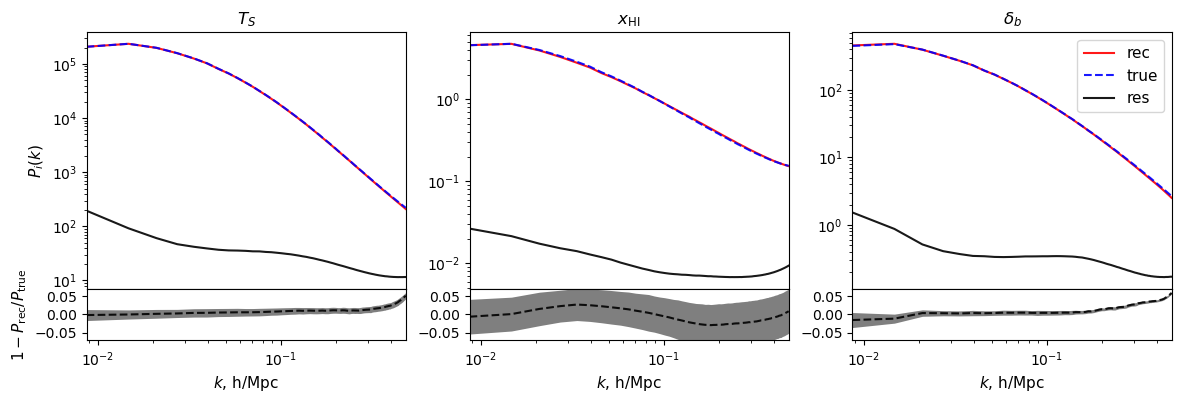

In [29]:
figsize=(14., 14./3.5)
fig, ax = plt.subplots(2, 3, sharex=True,figsize=figsize, gridspec_kw={'height_ratios': [5, 1],'hspace': 0})

kpow =0.
kcut = 78
als=0.9
lws = 1.5

P = P_tsrects
k= P[0][:,0][:kcut]

ax[0][0].set_title('$T_S$')
ax[0][0].set_ylabel("$P_{i}(k)$",{'fontsize':11})

ax[0][0].plot(k,k**kpow*Ptsrec,c='r',alpha=als,lw=lws,ls='-')
ax[0][0].plot(k,k**kpow*Pts,c='b',alpha=als,lw=lws,ls='--')
ax[0][0].plot(k,k**kpow*Prests,c='k',alpha=als,lw=lws,ls='-')

ax[0][1].set_title(r'$x_{\rm HI}$')
ax[0][1].plot(k,k**kpow*Pxrec,c='r',alpha=als,lw=lws,ls='-')
ax[0][1].plot(k,k**kpow*Px,c='b',alpha=als,lw=lws,ls='--')
ax[0][1].plot(k,k**kpow*Presx,c='k',alpha=als,lw=lws,ls='-')

ax[0][2].set_title('$\delta_b$')
ax[0][2].plot(k,k**kpow*Pdrec,c='r',alpha=als,lw=lws,ls='-',label='rec')
ax[0][2].plot(k,k**kpow*Pd,c='b',alpha=als,lw=lws,ls='--',label='true')
ax[0][2].plot(k,k**kpow*Presd,c='k',alpha=als,lw=lws,ls='-',label='res')
ax[0][2].legend(prop={'size': 11})


ax[1][0].set_ylabel(r'$1-P_{\rm rec}/P_{\rm true}$',{'fontsize':11})

diffi = (np.array(P_tsrects)[:,0:78,2]-np.array(P_tsrects)[:,0:78,1])/np.array(P_tsrects)[:,0:78,2]
diffim = np.mean(diffi,axis=0)
ddiff2i = np.std(diffi,axis=0)
ax[1][0].fill_between(k,diffim+ddiff2i,diffim-ddiff2i,color='k',alpha=0.5,lw=0)
ax[1][0].plot(k,diffim,c='k',alpha=als,lw=lws,ls='--')

diffi = (np.array(P_xrecx)[:,0:78,2]-np.array(P_xrecx)[:,0:78,1])/np.array(P_xrecx)[:,0:78,2]
diffim = np.mean(diffi,axis=0)
ddiff2i = np.std(diffi,axis=0)
ax[1][1].fill_between(k,diffim+ddiff2i,diffim-ddiff2i,color='k',alpha=0.5,lw=0)
ax[1][1].plot(k,diffim,c='k',alpha=als,lw=lws,ls='--')

diffi = (np.array(P_drecd)[:,0:78,2]-np.array(P_drecd)[:,0:78,1])/np.array(P_drecd)[:,0:78,2]
diffim = np.mean(diffi,axis=0)
ddiff2i = np.std(diffi,axis=0)
ax[1][2].fill_between(k,diffim+ddiff2i,diffim-ddiff2i,color='k',alpha=0.5,lw=0)
ax[1][2].plot(k,diffim,c='k',alpha=als,lw=lws,ls='--')


for i in ax[0]: i.set_yscale('log')
for i in ax[1]:
    i.set_ylim((-0.07,0.07))
    i.set_xlabel('$k$, h/Mpc',{'fontsize':11})

ax[0][0].set_xlim((k[0],k[-1]))
ax[0][0].set_xscale('log')

fig.savefig('./fig/allf_pk.pdf',bbox_inches='tight')

# plotting normalized cross-correlation power ${}^2$ (Figure 5)

In [30]:
def plot_mean_px(P,ax,cs,lbl,ls='-',als=1.,lws = 1.,kcut=78,poww=2):
    ptmp = np.zeros(P[0][:,2][:kcut].shape)
    ln = len(P)
    for i in range(ln):
        ptmp+=pcross(P,i,poww,kcut)/ln
    ax.plot(P[i][:,0][:kcut],ptmp,c=cs,alpha=als,lw=lws,label=lbl,ls=ls)

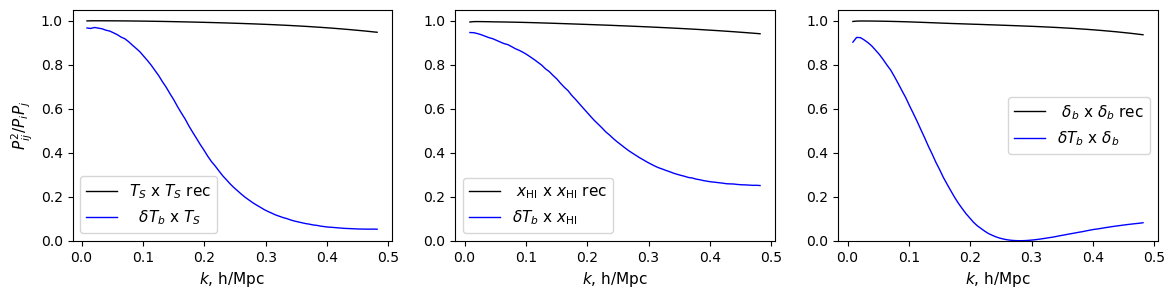

In [31]:
f,ax = plt.subplots(1,3)
f.set_figwidth(14.)
f.set_figheight(3.)

plot_mean_px(P_tsrects,ax[0],'k', "$T_S$ x $T_S$ rec")
plot_mean_px(P_tsrectb,ax[0],'b',"  $\delta T_b$ x $T_S$")

plot_mean_px(P_xrecx,ax[1],'k',r" $x_{\rm{HI}}$ x $x_{\rm{HI}}$ rec")
plot_mean_px(P_xtb,ax[1],'b',r"$ \delta T_b$ x $x_{\rm{HI}}$")

plot_mean_px(P_drecd,ax[2],'k', r" $\delta_b$ x $\delta_b$ rec")
plot_mean_px(P_dtb,ax[2],'b',r"$\delta T_b$ x $\delta_b$")

ax[0].set_ylabel("$P_{ij}^{2}/P_i P_j$",{'fontsize':11})

for i in range(3):
    ax[i].set_xlabel('$k$, h/Mpc',{'fontsize':11})
    ax[i].legend(prop={'size': 11})
    ax[i].set_ylim(0.,1.05)
f.savefig('./fig/allf_xcorrvmean.pdf',bbox_inches='tight')

# cross-correlation between different initial conditions realizaion (Figure A1)

In [32]:
### calculating cross-spectrum of i,i-1 field realisations
Pxsedd_rectrue_x = []
Pxsedd_inputtrue_x = []

Pxsedd_rectrue_d = []
Pxsedd_inputtrue_d = []

Pxsedd_rectrue_ts = []
Pxsedd_inputtrue_ts = []

for i in range(len(tb)):
    Pxsedd_rectrue_x.append(PkX(x_rec[i,:,:,:,0],1024.,x_rec[i-1,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    Pxsedd_inputtrue_x.append(PkX(x[i,:,:,:,0],1024.,x[i-1,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))

    Pxsedd_rectrue_d.append(PkX(d_rec[i,:,:,:,0],1024.,d_rec[i-1,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    Pxsedd_inputtrue_d.append(PkX(d[i,:,:,:,0],1024.,d[i-1,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))

    Pxsedd_rectrue_ts.append(PkX(ts_rec[i,:,:,:,0],1024.,ts_rec[i-1,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    Pxsedd_inputtrue_ts.append(PkX(ts[i,:,:,:,0],1024.,ts[i-1,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))


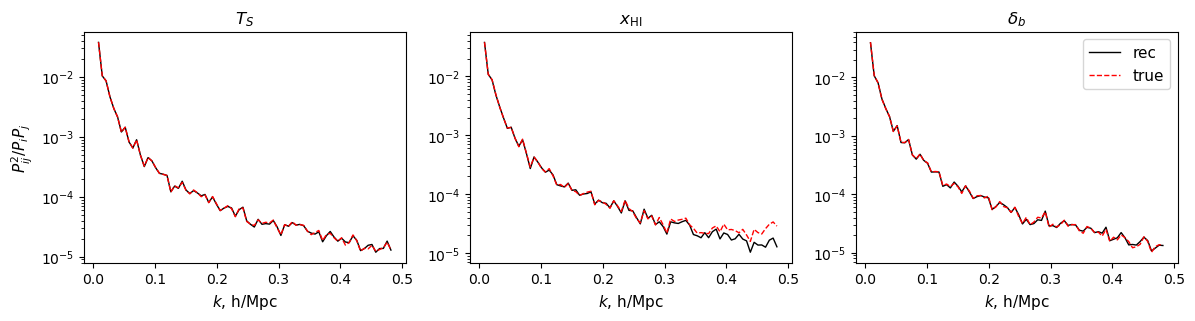

In [33]:
f,ax = plt.subplots(1,3)
f.set_figwidth(7.05556*2)
f.set_figheight(3.)
kcut = 78
als=1.
lws = 1.
poww=2.

plot_mean_px(Pxsedd_rectrue_ts,ax[0],'k','',poww=poww,lws=lws)
plot_mean_px(Pxsedd_inputtrue_ts,ax[0],'r','',poww=poww,ls='--')

plot_mean_px(Pxsedd_rectrue_x,ax[1],'k','',poww=poww,lws=lws)
plot_mean_px(Pxsedd_inputtrue_x,ax[1],'r','',poww=poww,ls='--')

plot_mean_px(Pxsedd_rectrue_d,ax[2],'k','rec',poww=poww,lws=lws)
plot_mean_px(Pxsedd_inputtrue_d,ax[2],'r','true',poww=poww,ls='--')

ax[0].set_ylabel("$P_{ij}^{2}/P_i P_j$",{'fontsize':11})

for i in range(3):
    ax[i].set_xlabel('$k$, h/Mpc',{'fontsize':11})

ax[0].set_title('$T_S$')
ax[1].set_title(r'$x_{\rm HI}$')
ax[2].set_title('$\delta_b$')
ax[-1].legend(prop={'size': 11})
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
f.savefig('./fig/xseed.pdf',bbox_inches='tight')